In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
# fmt: off

scouter = pd.read_csv("../extra/GI/GI_scores_scouter_trueab.csv")
truth = pd.read_csv("../extra/GI/GI_scores_truth.csv")
gears = pd.read_csv("../extra/GI/GI_scores_gears_trueab.csv")

metric_dict = {
    "synergy": "mag",
    "suppressor": "mag",
    "neomorphic": "corr_fit",
    "epistasis": "eq_contr",
    "redundant": "dcor",
}

largevalue_dict = {
    "synergy": True,
    "suppressor": False,
    "neomorphic": False,
    "epistasis": False,
    "redundant": True,
}

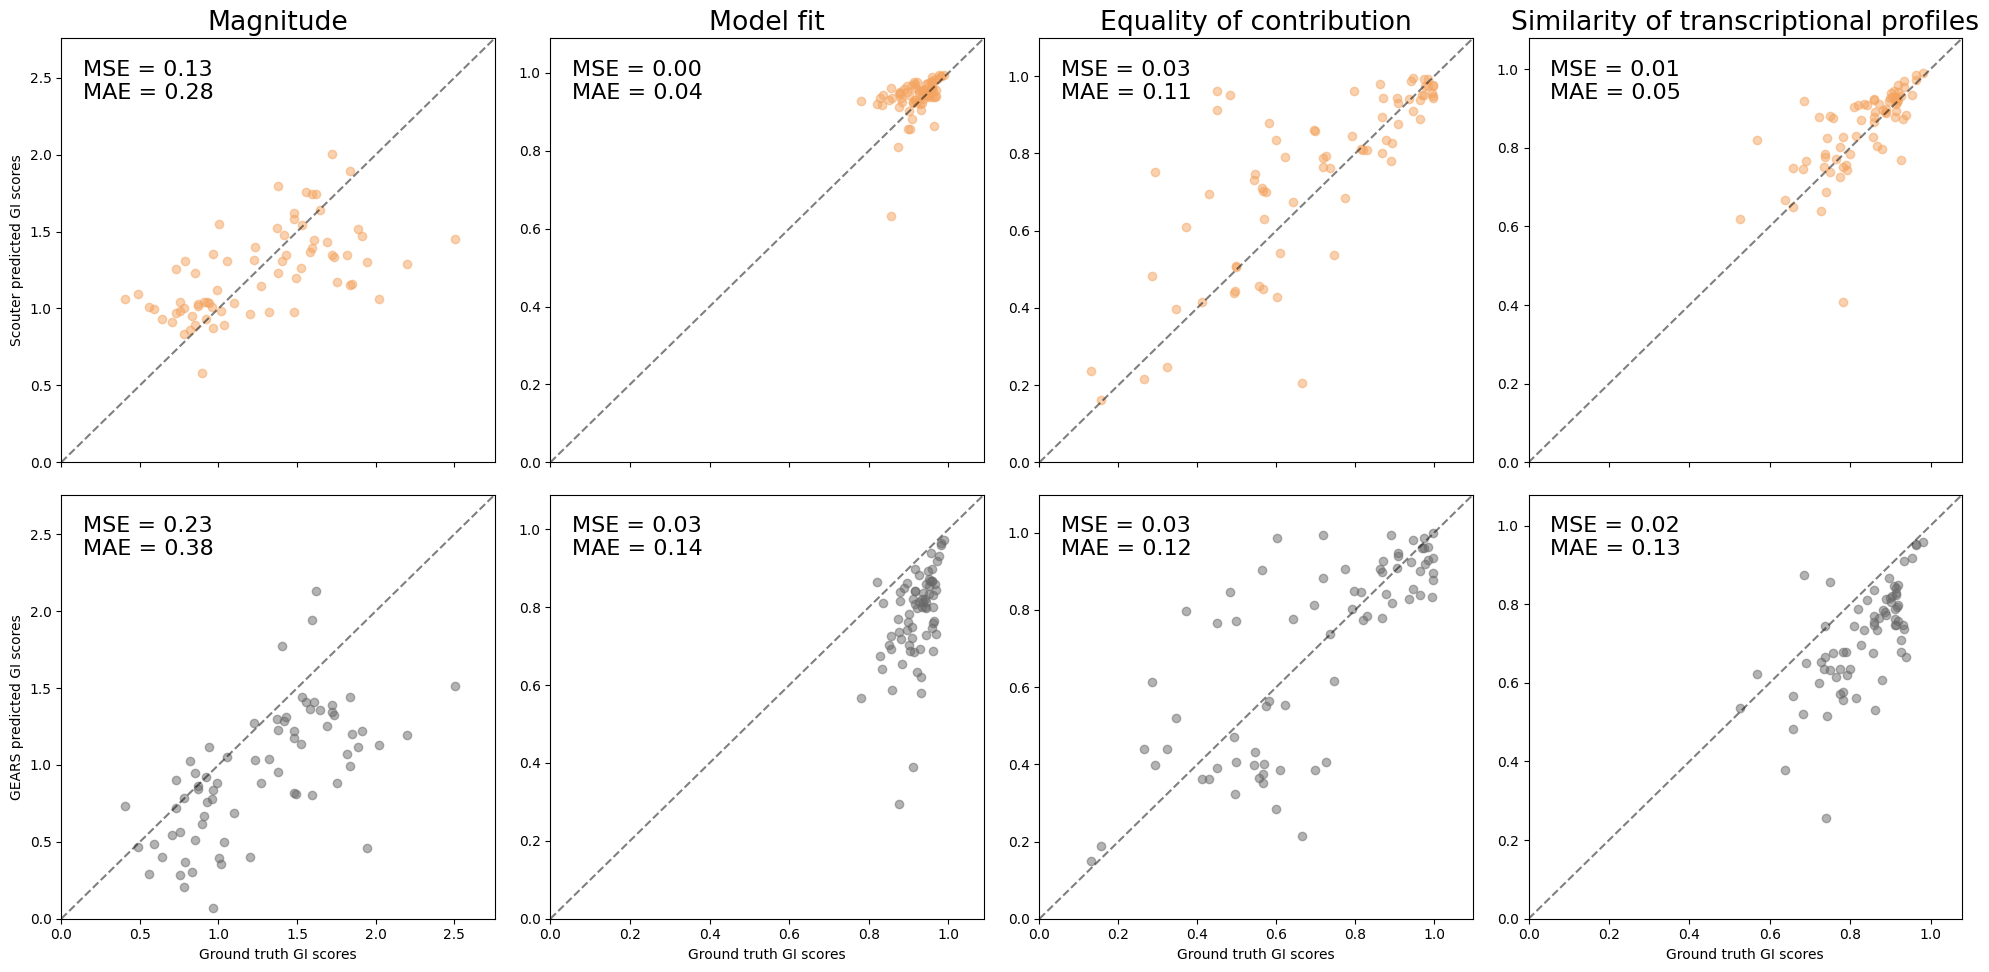

In [2]:
############################ Scatter plot #########################################
metrics = ['mag', 'corr_fit', 'eq_contr', 'dcor']
scatter_data = pd.concat([truth[metrics].assign(Method="Truth"),
                          scouter[metrics].assign(Method="Scouter"),
                          gears[metrics].assign(Method="GEARS")])
scatter_data.rename(columns={"mag": "Magnitude", "corr_fit": "Model fit", "eq_contr": "Equality of contribution", "dcor": "Similarity of transcriptional profiles"}, inplace=True)
title_names = ['Magnitude', 'Model fit', 'Equality of contribution', 'Similarity of transcriptional profiles']
metrics_data = []

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.rcParams.update({'font.size': 16})
for i, metric in enumerate(metrics):
    mse_scouter = np.mean((truth[metric] - scouter[metric])**2)
    mae_scouter = np.mean(np.abs(truth[metric] - scouter[metric]))
    mse_gears = np.mean((truth[metric] - gears[metric])**2)
    mae_gears = np.mean(np.abs(truth[metric] - gears[metric]))
    metrics_data.append(["MSE", metric, mse_scouter, mse_gears])
    metrics_data.append(["MAE", metric, mae_scouter, mae_gears])
    
    axes[0, i].scatter(truth[metric], scouter[metric], alpha=0.5, color='sandybrown')
    axes[0, i].plot([0, truth[metric].max()*1.2], [0, truth[metric].max()*1.2], 'k--', alpha=0.5)
    axes[0, i].text(0.05, 0.95, f'MSE = {mse_scouter:.2f}\nMAE = {mae_scouter:.2f}', transform=axes[0, i].transAxes, verticalalignment='top')
    if i == 0:
        axes[0, i].set_ylabel('Scouter predicted GI scores')
    axes[0, i].set_title(f'{title_names[i]}')
    axes[0, i].set_xlim(0, truth[metric].max()*1.1)
    axes[0, i].set_ylim(0, truth[metric].max()*1.1)
    axes[0, i].set_xticklabels([])
    
    axes[1, i].scatter(truth[metric], gears[metric], alpha=0.5, color='dimgrey')
    axes[1, i].plot([0, truth[metric].max()*1.2], [0, truth[metric].max()*1.2], 'k--', alpha=0.5)
    axes[1, i].text(0.05, 0.95, f'MSE = {mse_gears:.2f}\nMAE = {mae_gears:.2f}', transform=axes[1, i].transAxes, verticalalignment='top')
    axes[1, i].set_xlabel('Ground truth GI scores')
    if i == 0:
        axes[1, i].set_ylabel('GEARS predicted GI scores')
    axes[1, i].set_xlim(0, truth[metric].max()*1.1)
    axes[1, i].set_ylim(0, truth[metric].max()*1.1)

plt.tight_layout()
plt.show()

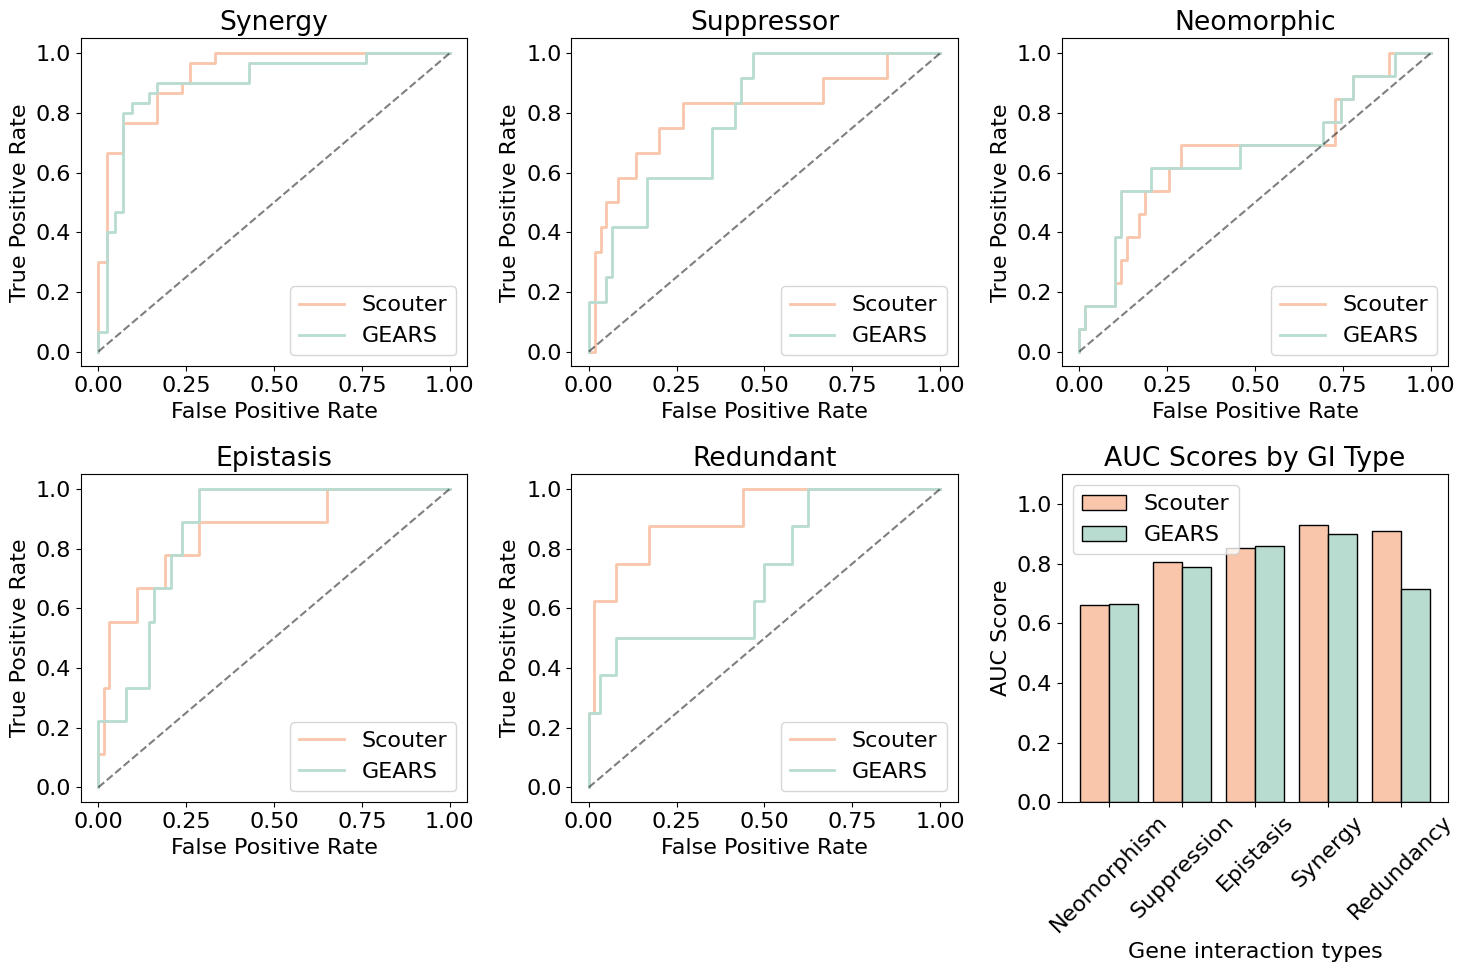

In [3]:
############################ AUC #########################################
colors = {"scouter": "#f9c5ab", "gears": "#b8dccf"}
auc_results = []
roc_data_ls = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for idx, (gi_type, metric) in enumerate(metric_dict.items()):
    # Calculate binary labels
    truth_binary = (truth.gi_type == gi_type).astype(int)
    # Calculate scores with proper direction
    reverse = 1 if largevalue_dict[gi_type] else -1
    scouter_scores = scouter[metric] * reverse
    gears_scores = gears[metric] * reverse
    # Get ROC curves
    fpr_scouter, tpr_scouter, _ = roc_curve(truth_binary, scouter_scores)
    fpr_gears, tpr_gears, _ = roc_curve(truth_binary, gears_scores)
    # save data
    roc_data = pd.DataFrame({
        "Method": ["Scouter"] * len(fpr_scouter) + ["GEARS"] * len(fpr_gears),
        "False Positive Rate": np.concatenate([fpr_scouter, fpr_gears]),
        "True Positive Rate": np.concatenate([tpr_scouter, tpr_gears])
    }).assign(GI_Type=gi_type.capitalize())
    roc_data_ls.append(roc_data)
    # Plot ROC curves
    axes[idx].plot(fpr_scouter, tpr_scouter, color=colors["scouter"], label='Scouter', linewidth=2)
    axes[idx].plot(fpr_gears, tpr_gears, color=colors["gears"], label='GEARS', linewidth=2)
    # Add diagonal line
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # Customize plot
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{gi_type.capitalize()}')
    axes[idx].legend(loc='lower right')
    # Calculate AUC scores for bar plot
    scouter_auc = roc_auc_score(truth_binary, scouter_scores)
    gears_auc = roc_auc_score(truth_binary, gears_scores)
    
    auc_results.append({
        "gi_type": gi_type.capitalize(),
        "Scouter": scouter_auc,
        "GEARS": gears_auc,
    })
roc_data = pd.concat(roc_data_ls)

# Create bar plot in the last subplot
auc_df = pd.DataFrame(auc_results)
auc_df = auc_df.set_index("gi_type")
auc_df.index = ["Synergy", "Suppression", "Neomorphism", "Epistasis", "Redundancy"]
auc_df = auc_df.loc[["Neomorphism", "Suppression", "Epistasis", "Synergy", "Redundancy"]]
auc_df.plot(kind="bar", ax=axes[-1], color=colors.values(), width=0.8, edgecolor="black")
axes[-1].set_xlabel("Gene interaction types")
axes[-1].set_ylabel("AUC Score")
axes[-1].set_title("AUC Scores by GI Type")
axes[-1].tick_params(axis='x', rotation=45)
axes[-1].legend(loc='upper left')
axes[-1].set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

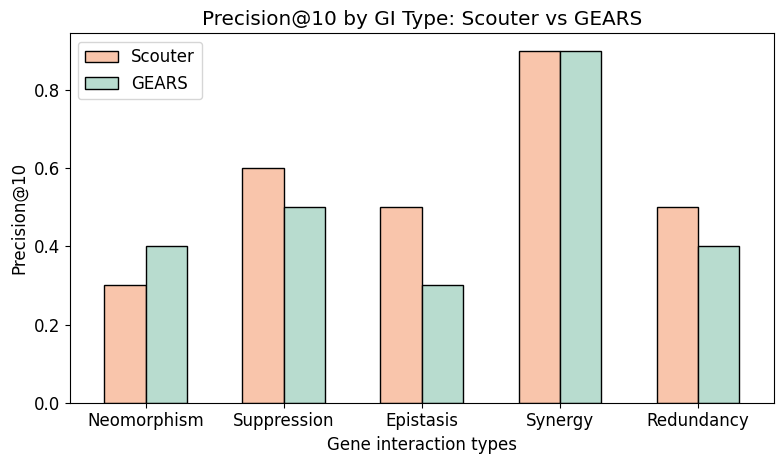

In [4]:

prec10 = []
for gi_type, metric in metric_dict.items():
    ascending = False if largevalue_dict[gi_type] else True
    scouter_top10 = scouter.sort_values(by=metric, ascending=ascending)[[metric, "gi_type"]].iloc[:10].gi_type.value_counts()
    gears_top10 = gears.sort_values(by=metric, ascending=ascending)[[metric, "gi_type"]].iloc[:10].gi_type.value_counts()
    scouter_top10_ratio = scouter_top10[gi_type] / 10
    gears_top10_ratio = gears_top10[gi_type] / 10
    prec10.append({
        "GI_Type": gi_type,
        "Scouter": scouter_top10_ratio,
        "GEARS": gears_top10_ratio,
    })
prec10 = pd.DataFrame(prec10)
prec10.set_index("GI_Type", inplace=True)
prec10.index = ["Synergy", "Suppression", "Neomorphism", "Epistasis", "Redundancy"]
prec10 = prec10.loc[["Neomorphism", "Suppression", "Epistasis", "Synergy", "Redundancy"]]  # fmt: skip
colors = {"scouter": "#f9c5ab", "gears": "#b8dccf"}

plt.rcParams.update({'font.size': 12})
prec10.plot(kind="bar", figsize=(8, 4.8), edgecolor="black", color=colors.values(), width=0.6)
plt.xlabel("Gene interaction types")
plt.xticks(rotation=0)
plt.ylabel("Precision@10")
plt.title("Precision@10 by GI Type: Scouter vs GEARS")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

